In [10]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [11]:
def benchmark(X, Y):
    return -((1.5 - X + X * Y)**2 + (2.25 - X + X * Y**2)**2 + (2.625 - X + X * Y**3)**2)


In [12]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [13]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [14]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-4.5, 4.5, 5)
Y = np.random.uniform(-4.5, 4.5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [15]:
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649

In [16]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [17]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32360766 -2.98273191]


In [18]:
df_sim = df.copy()

df_sim

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [19]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

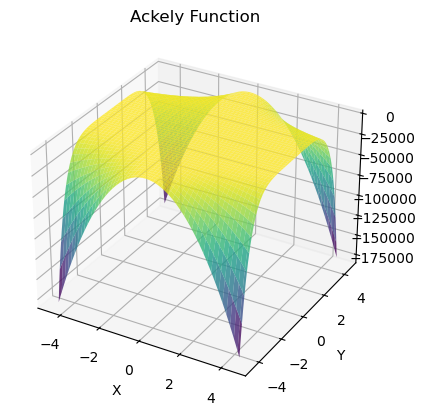

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackely Function')

# Show the plot
plt.show()

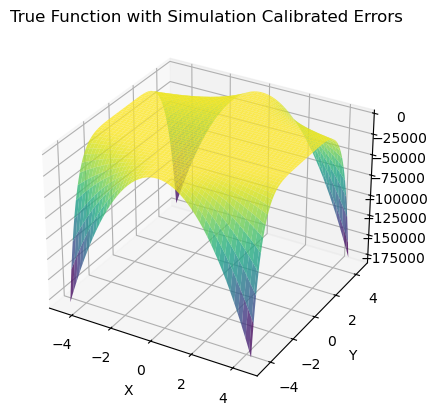

In [21]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [22]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [23]:
df_new = pd.DataFrame

In [24]:
obj_val_df = pd.DataFrame(columns=["Highest_Sim_Response", "Num_Points_In_df"])

In [25]:
round_val_df = pd.DataFrame(columns=["Highest_phy_Response", "Round_num"])

new_entry1 = pd.DataFrame({"Highest_phy_Response": [df['z'].max()],
                          "Round_num": [0]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [26]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )


    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=200, batch_size=128, verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-4.5, 4.5, 100)
    x2_range = np.linspace(-4.5, 4.5, 100)
    bounds = np.array([[-4.5, 4.5], [-4.5, 4.5]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    global obj_val_df
    # Append to tracking DataFrame
    new_entry = pd.DataFrame({
        "Highest_Sim_Response": [df2['sim_z'].max()],
        "Num_Points_In_df": [len(df)]
    })
    obj_val_df = pd.concat([obj_val_df, new_entry], ignore_index=True)

    return df, df2


Best hyperparameters:
num_layers: 7
num_units: 92
learning_rate: 0.0006815561443853911
dropout_rate: 0.23789117424218012
batch_size: 132
epochs: 86
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1626115.5000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1626107.1250
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1626099.5000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1625987.6250
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1626066.1250
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1625699.7500
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1625729.8750
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1625406.6250
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1625454.3750
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1625475.6250
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1625388.6250
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1624720.8750

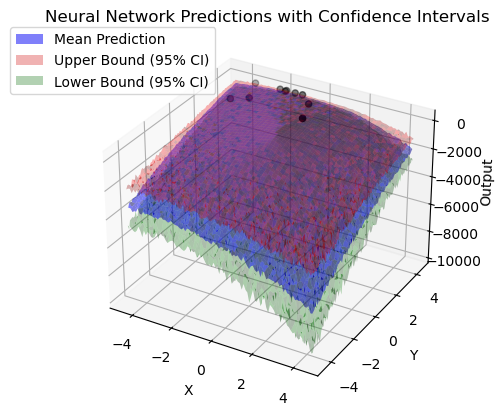

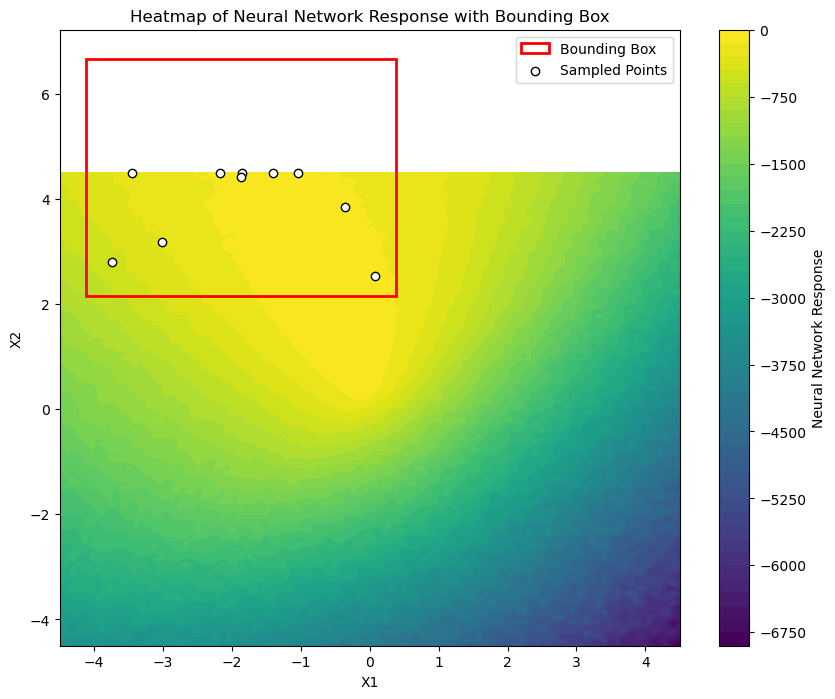

          x         y            z         a         b        sim_z      diff
5  0.073039  2.526414   -23.506738  4.323608 -2.982732   -23.474553 -0.032185
2 -0.362196  3.847896  -319.350510  4.323608 -2.982732  -319.278958 -0.071552
6 -3.747604  2.789429 -6183.520696  4.323608 -2.982732 -6183.990073  0.469378
4 -1.036108  4.500000 -8553.977990  4.323608 -2.982732 -8554.115720  0.137730
3 -3.010933  3.186019 -9082.001708  4.323608 -2.982732 -9082.409562  0.407854
           x         y             z         a         b         sim_z  \
0  -0.746802 -3.668953  -1695.133401  4.323608 -2.982732  -1694.266005   
1   1.982920 -2.823658  -2231.461373  4.323608 -2.982732  -2231.474423   
2  -4.498971 -1.389953   -522.757847  4.323608 -2.982732   -521.819231   
3  -1.779007 -0.929093    -64.660164  4.323608 -2.982732    -64.195661   
4  -3.179197  0.349351    -70.191649  4.323608 -2.982732    -69.863205   
5  -3.456876  4.500000 -99681.457577  4.323608 -2.982732 -99681.972198   
6  -1.849397  

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.005277059418245576
dropout_rate: 0.0
batch_size: 20
epochs: 184
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 890294016.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 890272640.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 890227072.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 890131456.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 889945024.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 889610368.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 889045760.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 888143488.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 886754496.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 884686464.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 881685824.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 877422

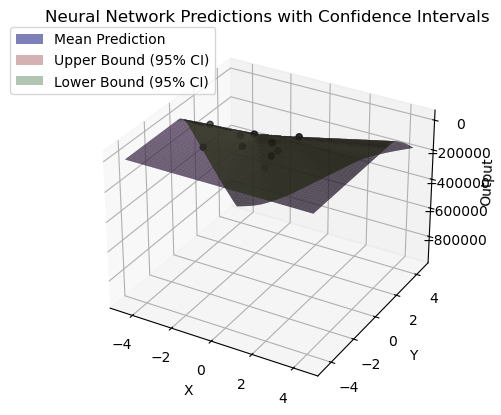

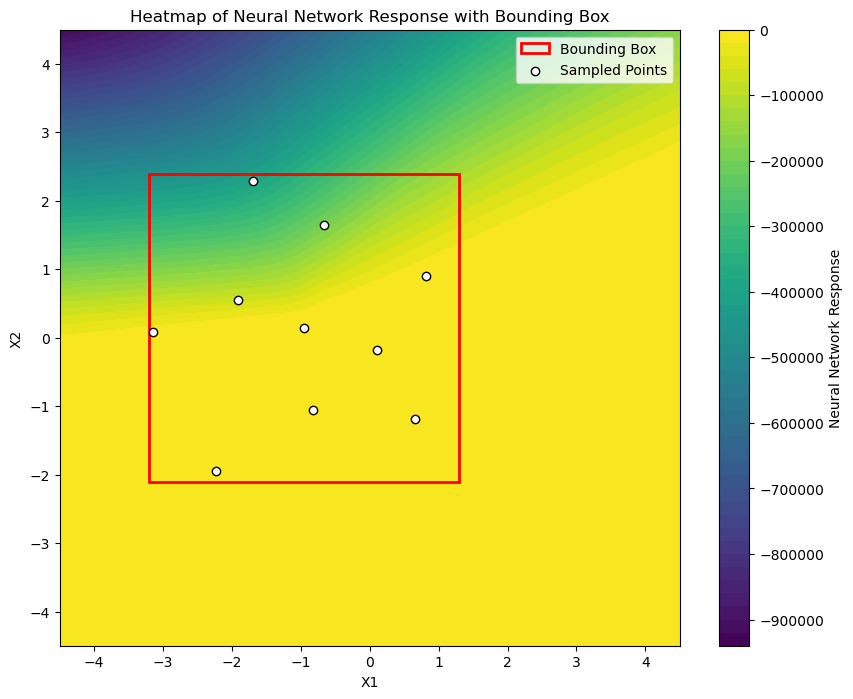

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 51
learning_rate: 0.006983654391386542
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 534191744.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 534187008.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 534179424.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 534168128.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 534152512.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 534131168.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 534101824.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 534061472.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 534007424.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 533934944.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 533838304.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 533711

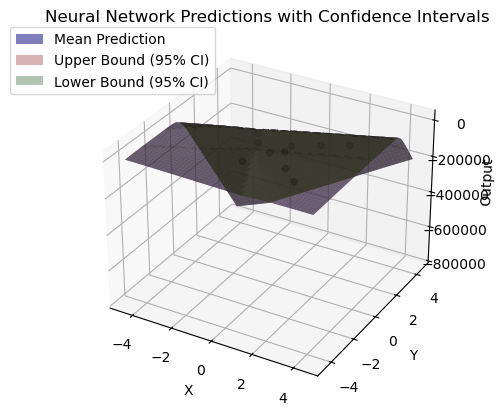

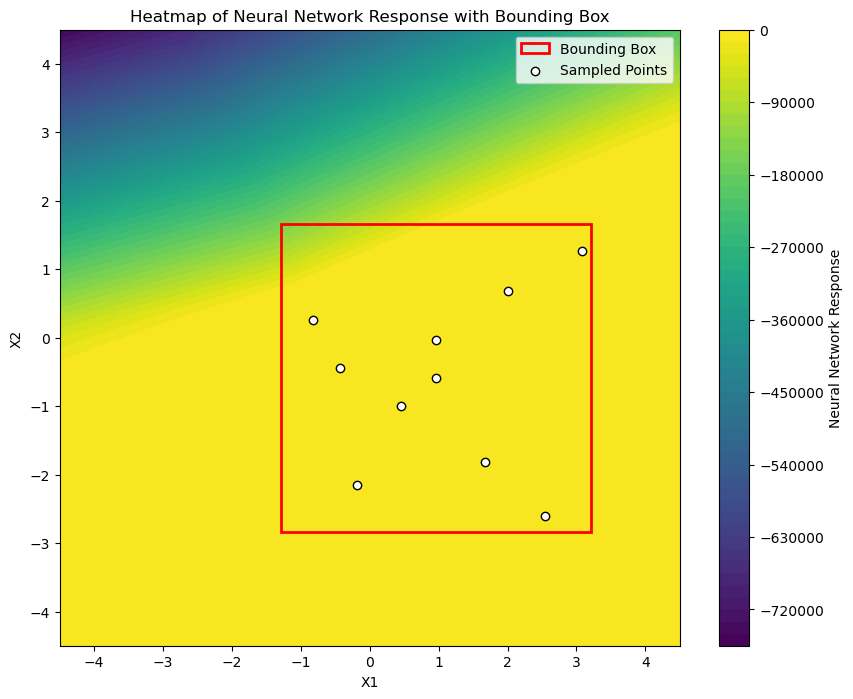

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.0028526073143899672
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 381724832.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 381721056.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 381710400.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 381683296.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 381622784.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 381492320.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 381221728.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 380689152.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 379688928.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 377880576.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 374711360.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 36937

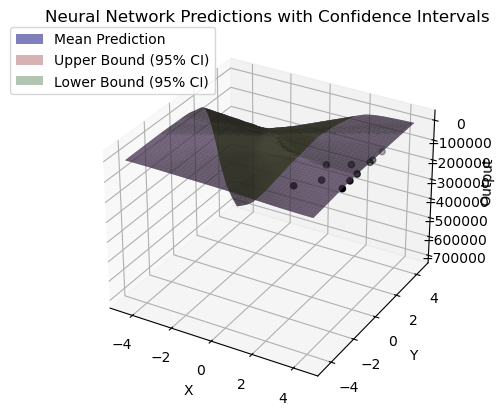

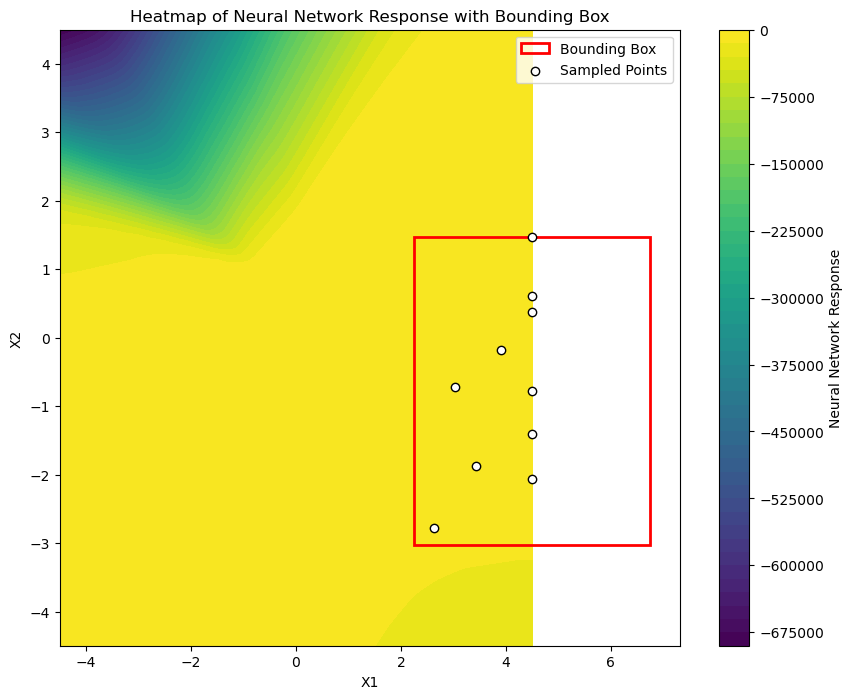

In [30]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 129
learning_rate: 0.0019116164107177876
dropout_rate: 0.0
batch_size: 106
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 297306720.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 297304032.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 297300000.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 297292960.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 297280832.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 297260640.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 297228128.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 297176000.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 297092608.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 296960736.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 296754016.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2964

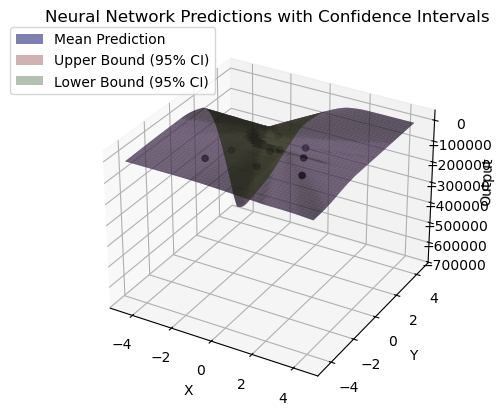

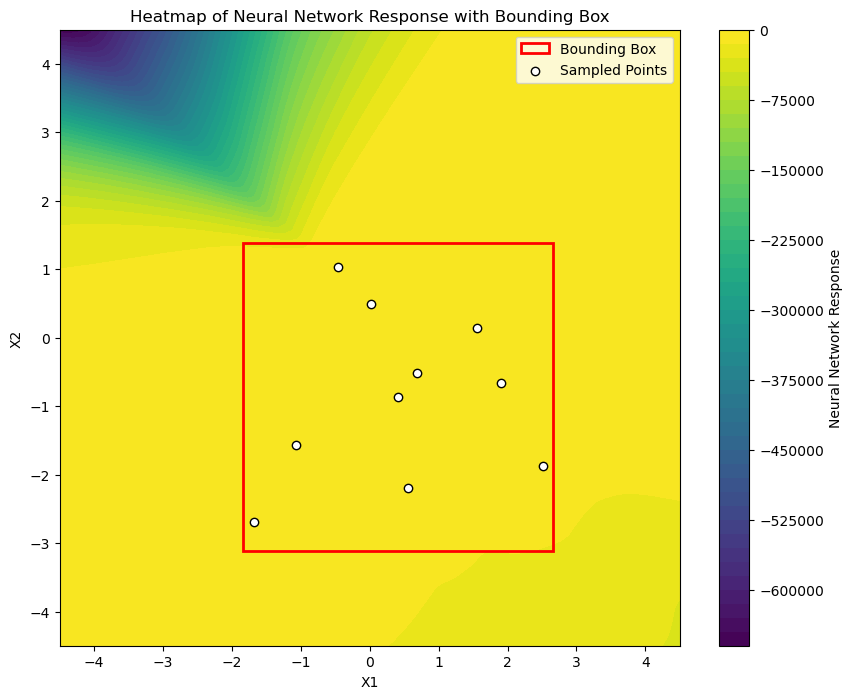

In [31]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.0036272860322043112
dropout_rate: 0.0
batch_size: 80
epochs: 142
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 243295072.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 243289568.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 243268704.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 243207120.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 243045008.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 242654096.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 241785152.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 239978976.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 236455040.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 230066736.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 219295504.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20241

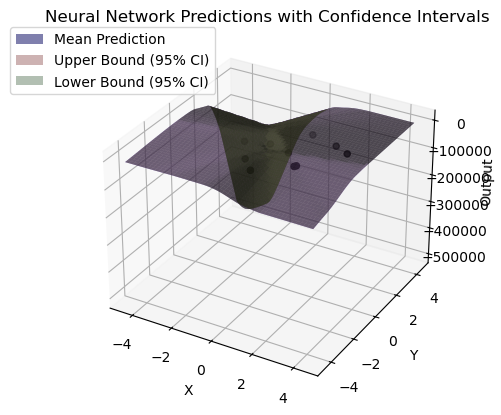

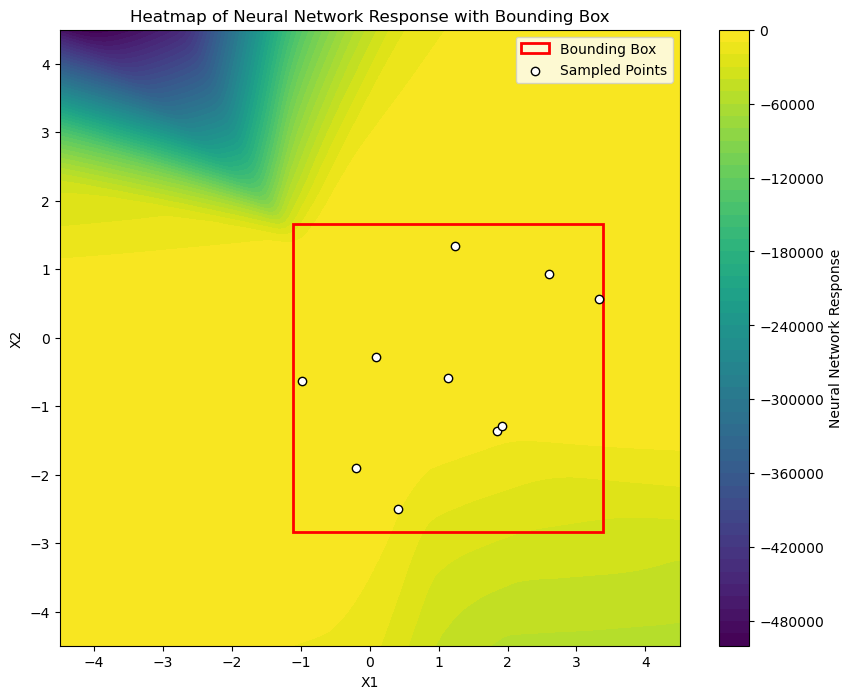

          x         y          z         a         b      sim_z      diff
3  3.322772  0.560705  -0.080036  4.323608 -2.982732   0.136810 -0.216847
9  1.136364 -0.590909  -3.921223  4.323608 -2.982732  -3.944081  0.022858
5  2.594960  0.933357  -9.974314  4.323608 -2.982732  -9.864964 -0.109350
7  0.086201 -0.283774 -13.173089  4.323608 -2.982732 -13.087659 -0.085430
4 -0.202624 -1.902852 -25.039835  4.323608 -2.982732 -25.158686  0.118851
           x         y            z         a         b        sim_z      diff
0  -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1   1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2  -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3  -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4  -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
..       ...       ...          ...       ...       ...          ...       ...
60 

In [32]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

In [33]:
df_new

x         y          z         a         b      sim_z      diff
3  3.322772  0.560705  -0.080036  4.323608 -2.982732   0.136810 -0.216847
9  1.136364 -0.590909  -3.921223  4.323608 -2.982732  -3.944081  0.022858
5  2.594960  0.933357  -9.974314  4.323608 -2.982732  -9.864964 -0.109350
7  0.086201 -0.283774 -13.173089  4.323608 -2.982732 -13.087659 -0.085430
4 -0.202624 -1.902852 -25.039835  4.323608 -2.982732 -25.158686  0.118851

In [34]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445

In [35]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.5171819410172759


In [36]:
df = pd.concat([df, df_new], ignore_index=True)
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.323608 -2.982732 -1694.266005 -0.867396
1  1.982920 -2.823658 -2231.461373  4.323608 -2.982732 -2231.474423  0.013050
2 -4.498971 -1.389953  -522.757847  4.323608 -2.982732  -521.819231 -0.938616
3 -1.779007 -0.929093   -64.660164  4.323608 -2.982732   -64.195661 -0.464503
4 -3.179197  0.349351   -70.191649  4.323608 -2.982732   -69.863205 -0.328445
5  3.322772  0.560705    -0.080036  4.323608 -2.982732     0.136810 -0.216847
6  1.136364 -0.590909    -3.921223  4.323608 -2.982732    -3.944081  0.022858
7  2.594960  0.933357    -9.974314  4.323608 -2.982732    -9.864964 -0.109350
8  0.086201 -0.283774   -13.173089  4.323608 -2.982732   -13.087659 -0.085430
9 -0.202624 -1.902852   -25.039835  4.323608 -2.982732   -25.158686  0.118851

In [37]:
df = df.iloc[:, :-4]
df

x         y            z
0 -0.746802 -3.668953 -1695.133401
1  1.982920 -2.823658 -2231.461373
2 -4.498971 -1.389953  -522.757847
3 -1.779007 -0.929093   -64.660164
4 -3.179197  0.349351   -70.191649
5  3.322772  0.560705    -0.080036
6  1.136364 -0.590909    -3.921223
7  2.594960  0.933357    -9.974314
8  0.086201 -0.283774   -13.173089
9 -0.202624 -1.902852   -25.039835

In [38]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 4.04934429 -2.97196511]


In [39]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  0.5, "Z": benchmark( 3,  0.5)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X    Y    Z
0  3  0.5 -0.0

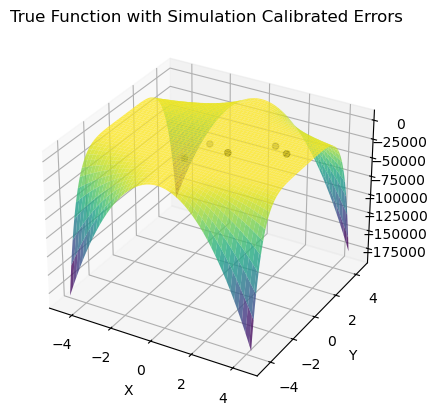

In [40]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [41]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new['z'].max()],
                          "Round_num": [1]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [42]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.049344 -2.971965 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.049344 -2.971965 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.049344 -2.971965  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.049344 -2.971965   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.049344 -2.971965   -70.288401  0.096751
5  3.322772  0.560705    -0.080036  4.049344 -2.971965    -0.006953 -0.073083
6  1.136364 -0.590909    -3.921223  4.049344 -2.971965    -3.992519  0.071296
7  2.594960  0.933357    -9.974314  4.049344 -2.971965    -9.979811  0.005497
8  0.086201 -0.283774   -13.173089  4.049344 -2.971965   -13.088838 -0.084251
9 -0.202624 -1.902852   -25.039835  4.049344 -2.971965   -25.165532  0.125696

In [43]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -0.008614979313308263


In [44]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

          x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.049344 -2.971965 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.049344 -2.971965 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.049344 -2.971965  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.049344 -2.971965   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.049344 -2.971965   -70.288401  0.096751


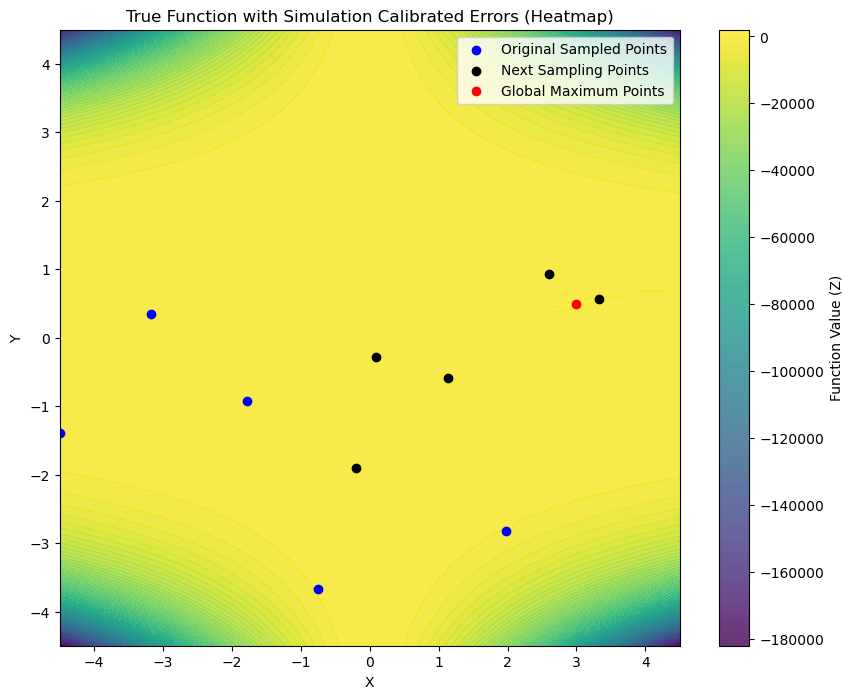

In [45]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [46]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 6
num_units: 199
learning_rate: 0.0001238283191162302
dropout_rate: 0.3689772391985876
batch_size: 71
epochs: 143
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 813764.7500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 813817.6250
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 813843.0625
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 813783.6875
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 813746.6250
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 813686.1250
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 813632.5625
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 813728.0625
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 813733.6250
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 813645.3750
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 813717.1875
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 813674.9375
Epoch 13/20

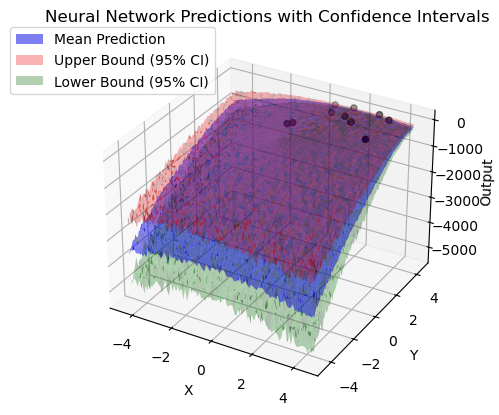

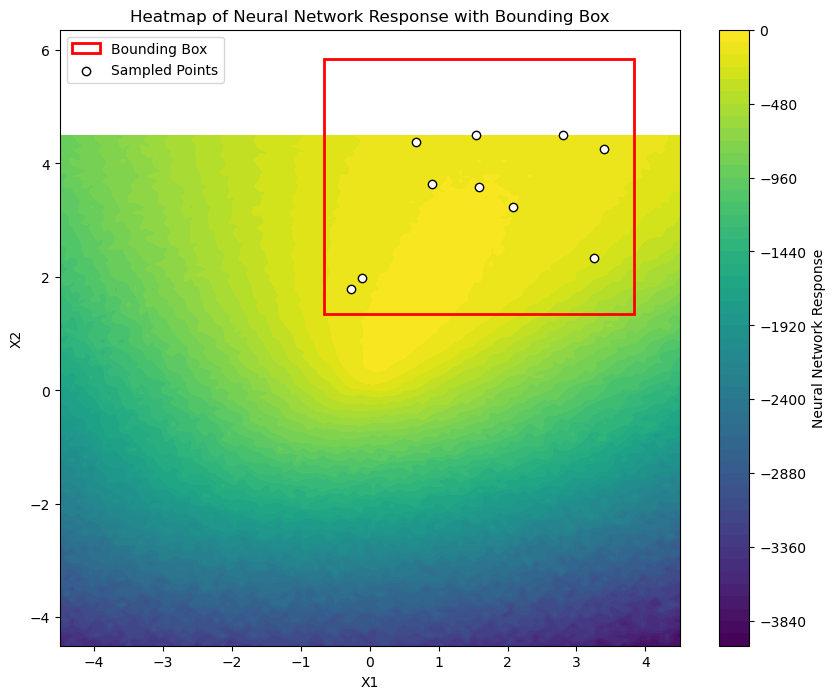

In [47]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 200
learning_rate: 0.0030133665166371167
dropout_rate: 0.0
batch_size: 138
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 523379360.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 523366400.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 523334656.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 523263168.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 523115328.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 522827456.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 522292640.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 521345728.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 519735648.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 517095616.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 512902240.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5064

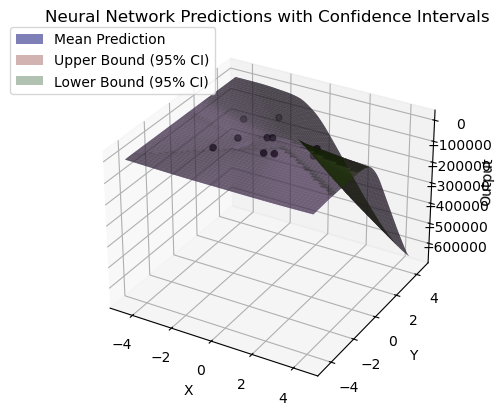

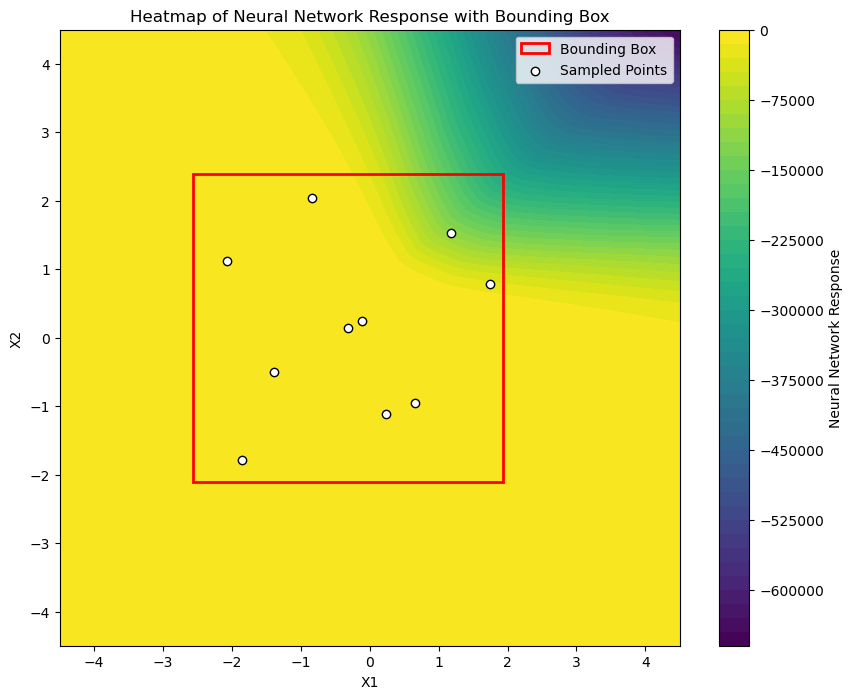

In [48]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.00307834834487751
dropout_rate: 0.0
batch_size: 150
epochs: 169
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 348923040.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 348920768.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 348906848.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 348852832.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 348670784.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 348119104.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 346557152.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 342485056.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 332732224.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 311299136.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 269904320.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 21307

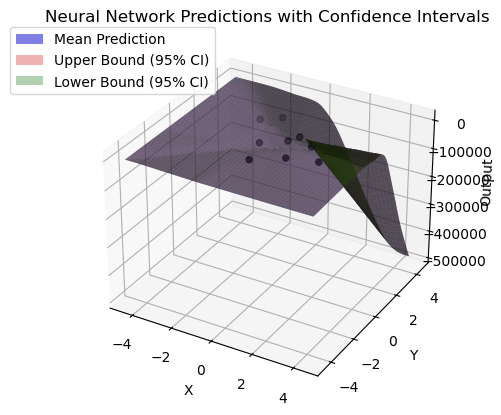

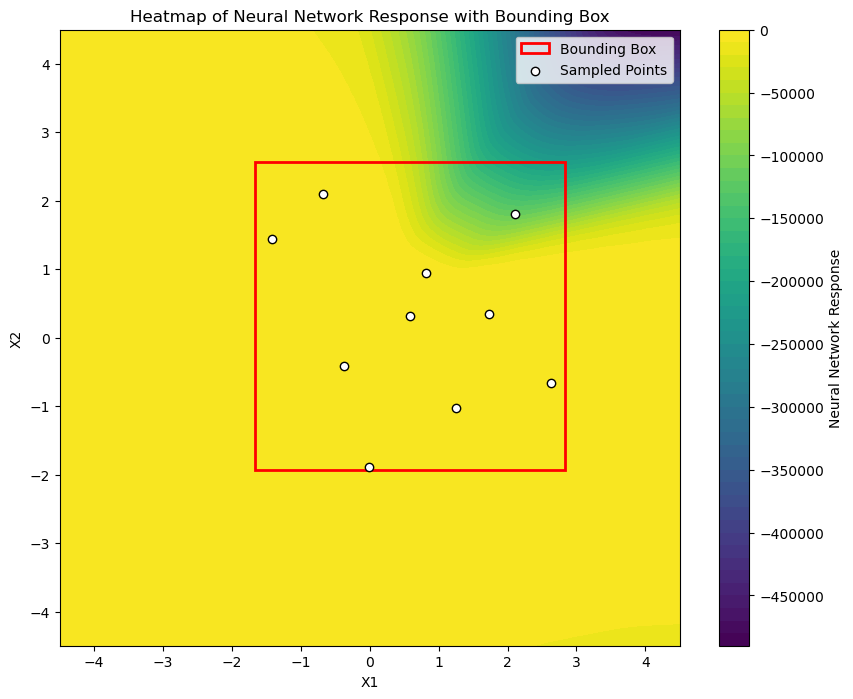

In [49]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 175
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step - loss: 261692592.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 261609376.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 261387216.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 260928416.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 260140080.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 258914592.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 257145680.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 254722640.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 251527136.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 247440736.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 242356960.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 236191664.0000
Epoch

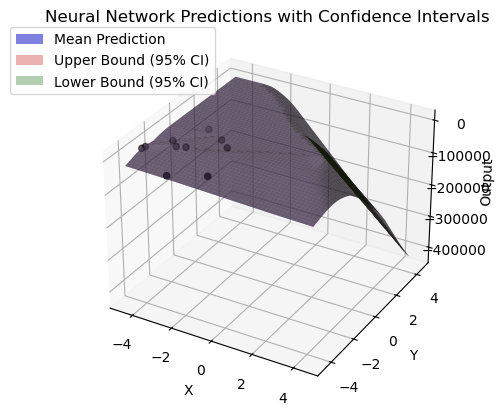

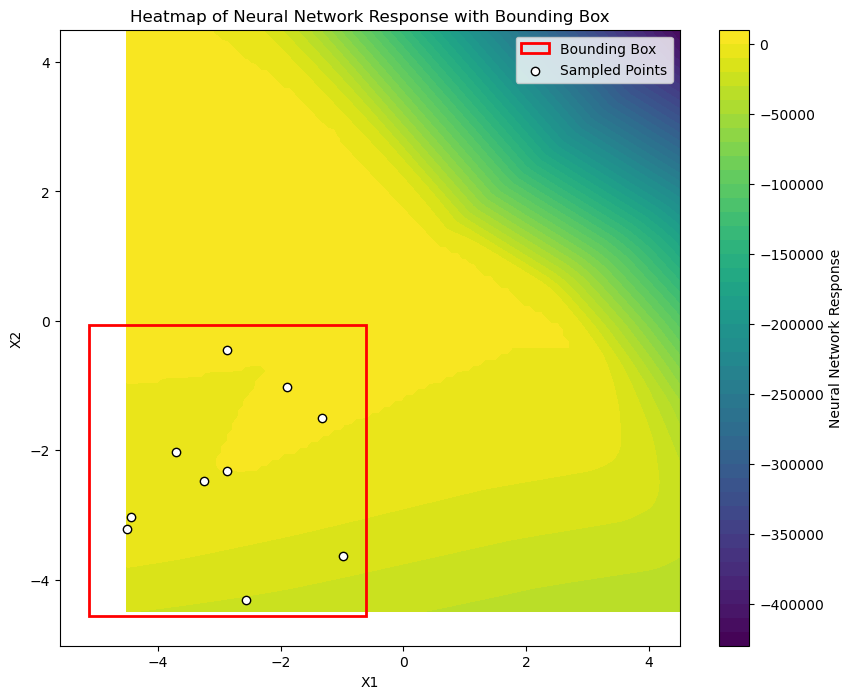

In [50]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 90
learning_rate: 0.009041060482586469
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 275149024.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 275137440.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 275106496.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 275029984.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 274860736.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 274510848.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 273845920.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 272658304.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 270643104.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 267384320.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 262342352.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 254870

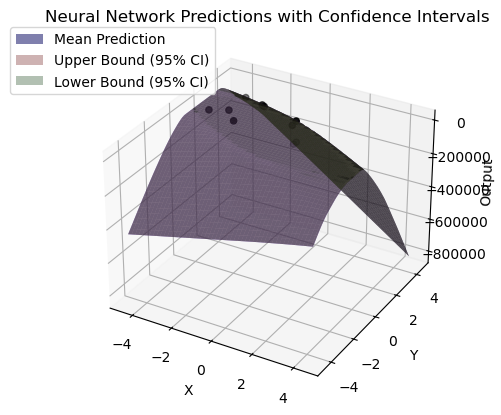

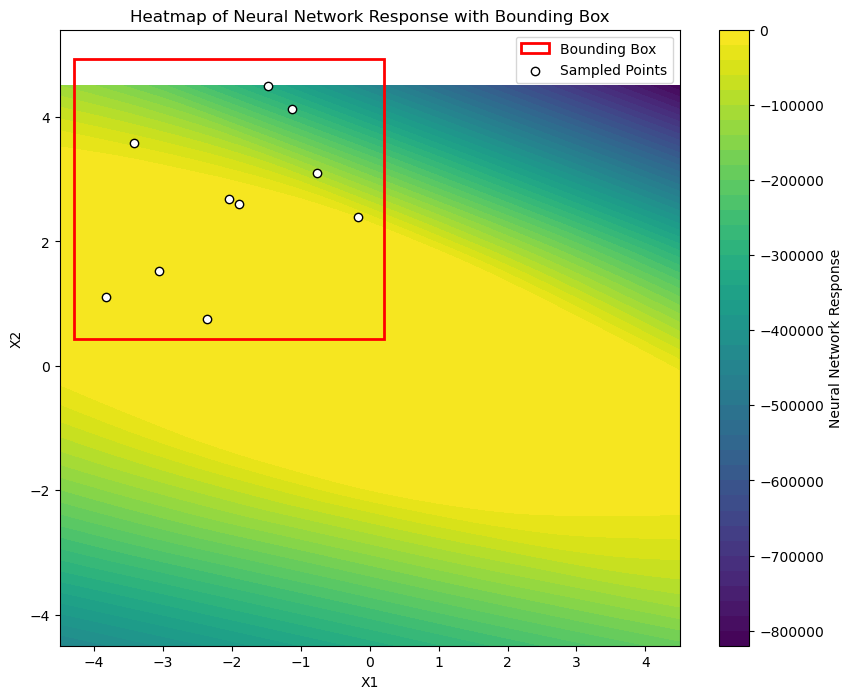

In [51]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 111
learning_rate: 0.0016350032597254192
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 245328624.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 245328112.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 245327120.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 245325280.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 245321984.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 245316352.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 245307024.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 245291696.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 245267024.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 245227248.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 245163776.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2450

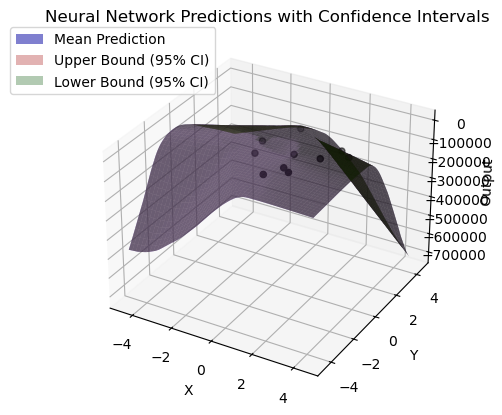

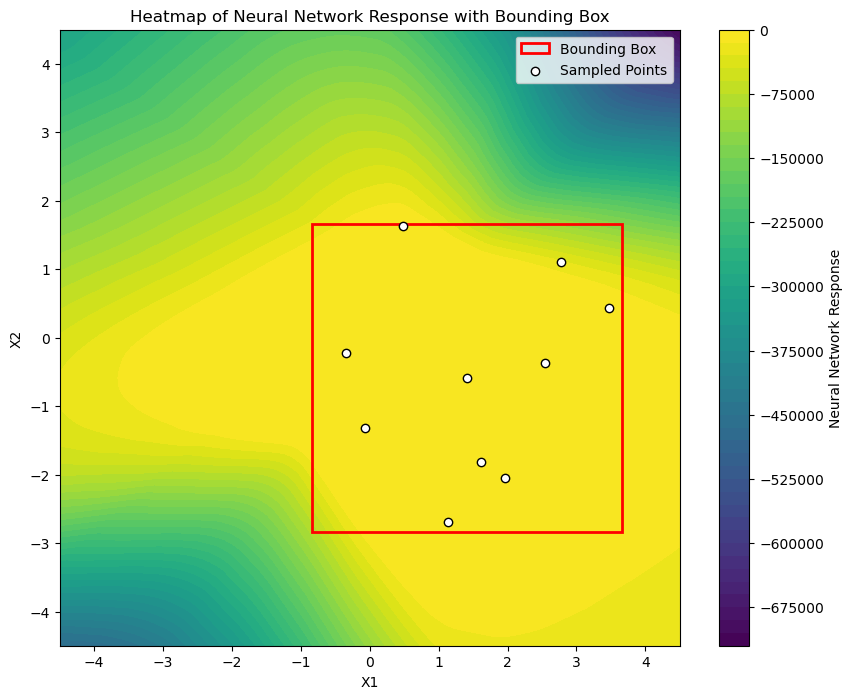

In [52]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [53]:
df_new2

x         y          z         a         b      sim_z      diff
0  3.471135  0.434132  -0.905159  4.049344 -2.971965  -0.814849 -0.090310
9  1.409091 -0.590909  -3.232708  4.049344 -2.971965  -3.224917 -0.007791
3  2.546196 -0.376279  -3.887663  4.049344 -2.971965  -4.065040  0.177377
5 -0.070144 -1.318581 -15.799904  4.049344 -2.971965 -15.772566 -0.027338
4 -0.342777 -0.223519 -19.167782  4.049344 -2.971965 -19.172387  0.004605

In [54]:
df

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.049344 -2.971965 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.049344 -2.971965 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.049344 -2.971965  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.049344 -2.971965   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.049344 -2.971965   -70.288401  0.096751
5  3.322772  0.560705    -0.080036  4.049344 -2.971965    -0.006953 -0.073083
6  1.136364 -0.590909    -3.921223  4.049344 -2.971965    -3.992519  0.071296
7  2.594960  0.933357    -9.974314  4.049344 -2.971965    -9.979811  0.005497
8  0.086201 -0.283774   -13.173089  4.049344 -2.971965   -13.088838 -0.084251
9 -0.202624 -1.902852   -25.039835  4.049344 -2.971965   -25.165532  0.125696

In [55]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x         y            z         a         b        sim_z      diff
0  -0.746802 -3.668953 -1695.133401  4.049344 -2.971965 -1695.119001 -0.014399
1   1.982920 -2.823658 -2231.461373  4.049344 -2.971965 -2231.668855  0.207481
2  -4.498971 -1.389953  -522.757847  4.049344 -2.971965  -522.515883 -0.241964
3  -1.779007 -0.929093   -64.660164  4.049344 -2.971965   -64.480989 -0.179175
4  -3.179197  0.349351   -70.191649  4.049344 -2.971965   -70.288401  0.096751
5   3.322772  0.560705    -0.080036  4.049344 -2.971965    -0.006953 -0.073083
6   1.136364 -0.590909    -3.921223  4.049344 -2.971965    -3.992519  0.071296
7   2.594960  0.933357    -9.974314  4.049344 -2.971965    -9.979811  0.005497
8   0.086201 -0.283774   -13.173089  4.049344 -2.971965   -13.088838 -0.084251
9  -0.202624 -1.902852   -25.039835  4.049344 -2.971965   -25.165532  0.125696
10  3.471135  0.434132    -0.905159  4.049344 -2.971965    -0.814849 -0.090310
11  1.409091 -0.590909    -3.232708  4.049344 -2.971965    -3.224917 -0.007791
12  2.546196 -0.376279    -3.887663  4.049344 -2.971965    -4.065040  0.177377
13 -0.070144 -1.318581   -15.799904  4.049344 -2.971965   -15.772566 -0.027338
14 -0.342777 -0.223519   -19.167782  4.049344 -2.971965   -19.172387  0.004605

In [56]:
df = df.iloc[:, :-4]
df

x         y            z
0  -0.746802 -3.668953 -1695.133401
1   1.982920 -2.823658 -2231.461373
2  -4.498971 -1.389953  -522.757847
3  -1.779007 -0.929093   -64.660164
4  -3.179197  0.349351   -70.191649
5   3.322772  0.560705    -0.080036
6   1.136364 -0.590909    -3.921223
7   2.594960  0.933357    -9.974314
8   0.086201 -0.283774   -13.173089
9  -0.202624 -1.902852   -25.039835
10  3.471135  0.434132    -0.905159
11  1.409091 -0.590909    -3.232708
12  2.546196 -0.376279    -3.887663
13 -0.070144 -1.318581   -15.799904
14 -0.342777 -0.223519   -19.167782

In [57]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new2['z'].max()],
                          "Round_num": [2]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [58]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.07300349 -2.97490271]


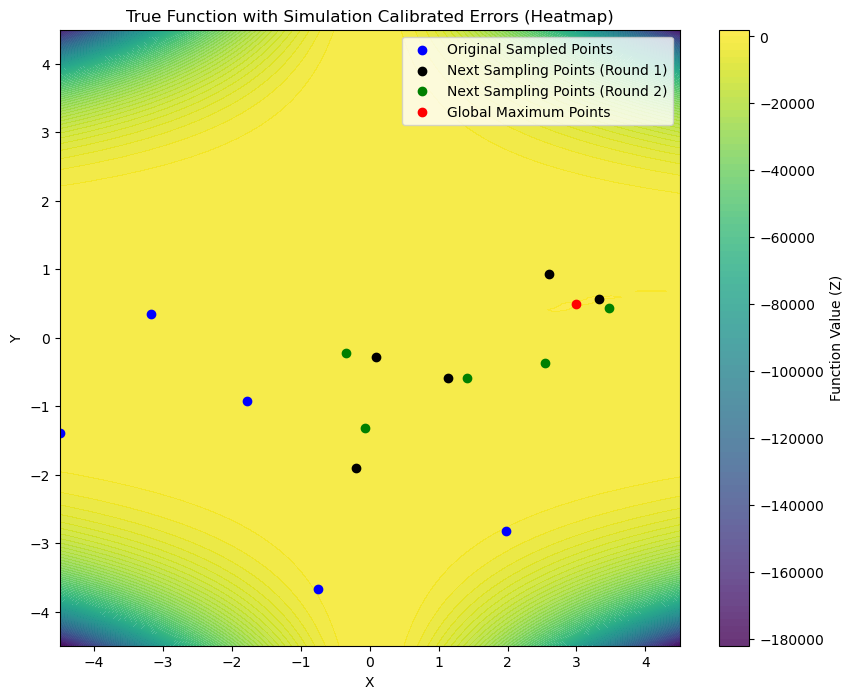

In [59]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [60]:
df_original

x         y            z         a         b        sim_z      diff
0 -0.746802 -3.668953 -1695.133401  4.049344 -2.971965 -1695.119001 -0.014399
1  1.982920 -2.823658 -2231.461373  4.049344 -2.971965 -2231.668855  0.207481
2 -4.498971 -1.389953  -522.757847  4.049344 -2.971965  -522.515883 -0.241964
3 -1.779007 -0.929093   -64.660164  4.049344 -2.971965   -64.480989 -0.179175
4 -3.179197  0.349351   -70.191649  4.049344 -2.971965   -70.288401  0.096751

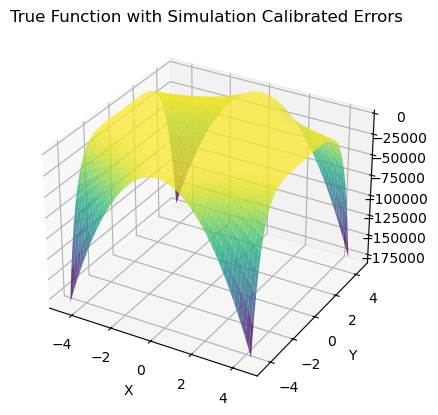

In [61]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [62]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -0.080036         1
2             -0.905159         2

In [63]:
df_new3 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 8
num_units: 200
learning_rate: 0.0012123126048854697
dropout_rate: 0.13487726682981438
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 542386.1875
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 542332.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 542280.6875
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 542098.2500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 541948.2500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 541570.6250
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 541043.9375
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 540193.5000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 539500.5625
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 536374.5000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 534218.5625
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 529443.8750
Epoch 13/

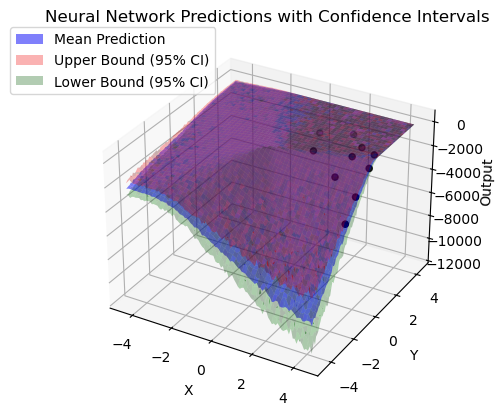

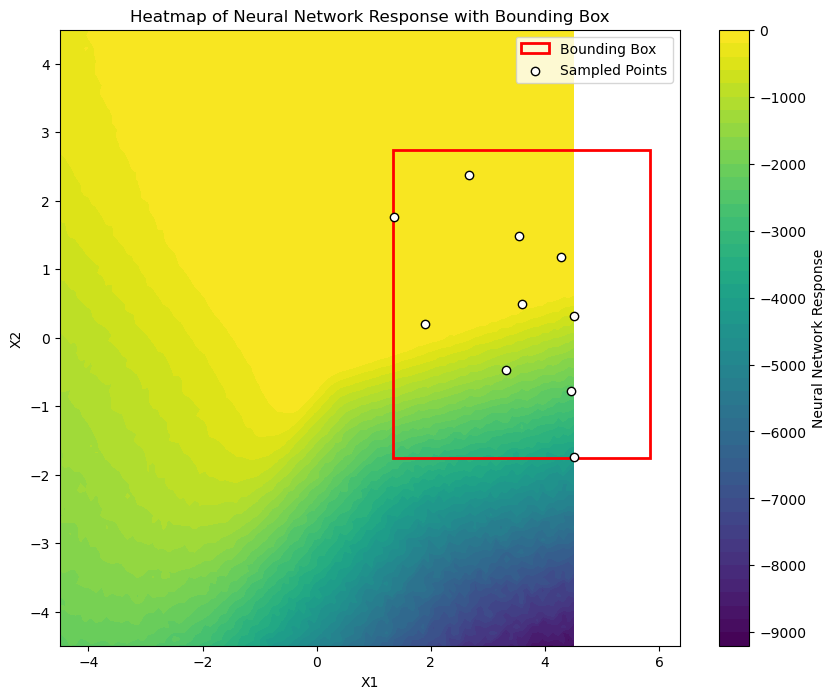

In [64]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 173
learning_rate: 0.0031907096860534713
dropout_rate: 0.24921928488506234
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 449566.9062
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 449408.8125
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 448718.1875
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 445953.6875
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 433769.6250
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 410777.5938
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 344703.2500
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 240709.3125
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 217182.4062
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 187180.7031
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 235693.2344
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 212847.5938
Epoch 13/

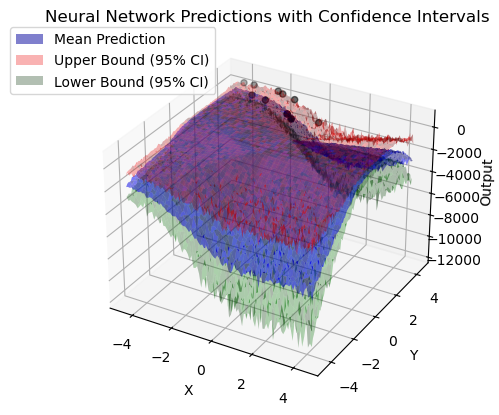

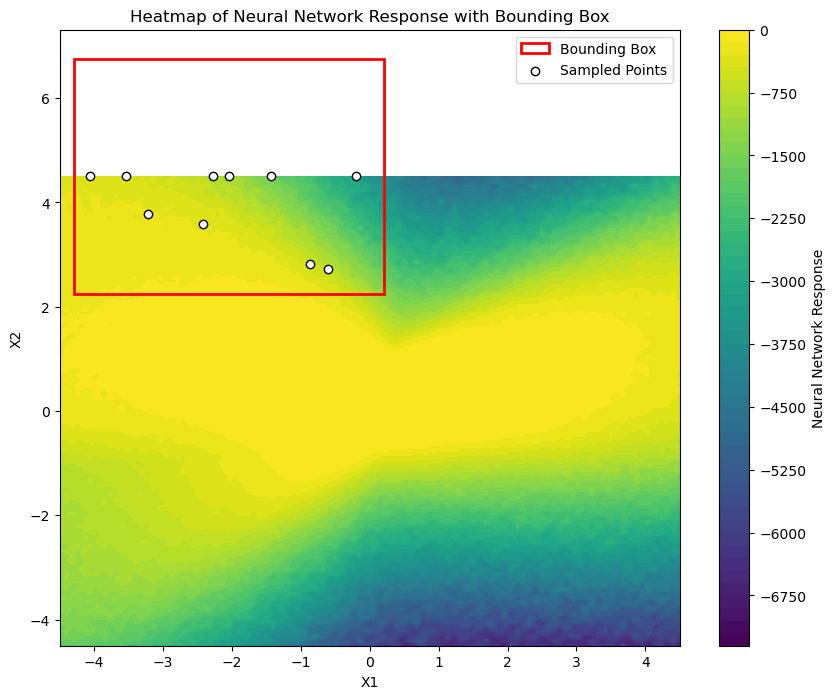

In [65]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 97
learning_rate: 0.002449570414314282
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 977460864.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 977458880.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 977456000.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 977451648.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 977443968.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 977431680.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 977411776.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 977379968.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 977329024.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 977248448.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 977122304.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 976927

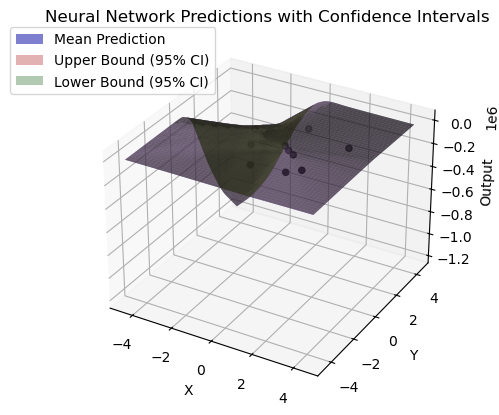

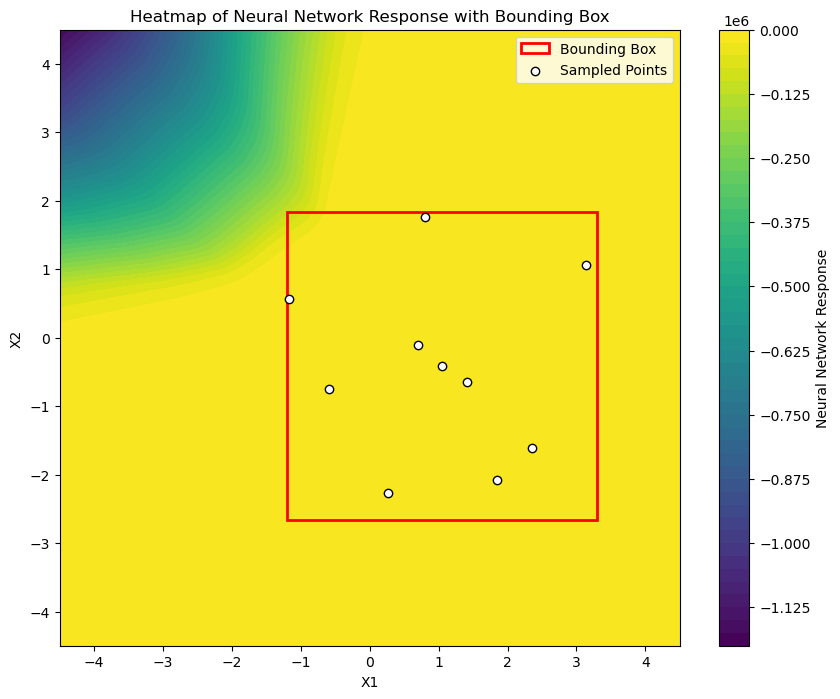

In [66]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 3
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 130
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 760251392.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 760017600.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 758928256.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 755770624.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 748619200.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 735118464.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 711951680.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 675591488.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 623048448.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 553725376.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 473348192.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 401960288.0000
Epoch 13

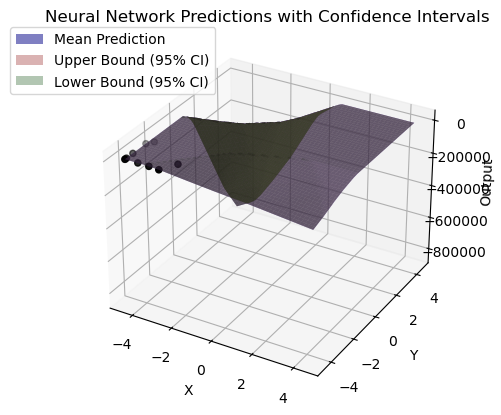

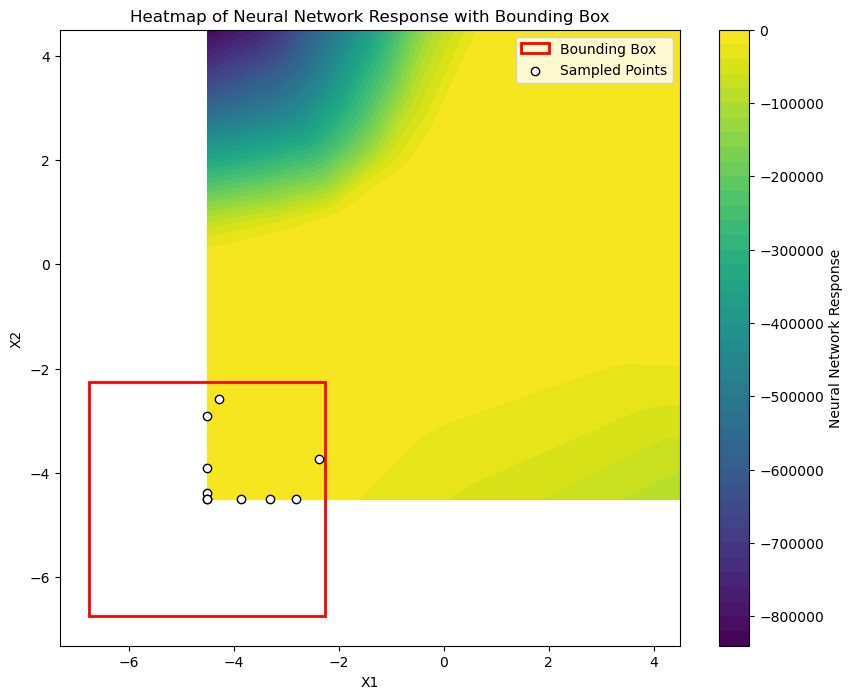

In [67]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.027790961914816656
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3000170240.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2998829568.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2988230144.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2948213248.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2838441728.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2594550272.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2150425600.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1554561536.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1403458304.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1774449024.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1339756160.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - 

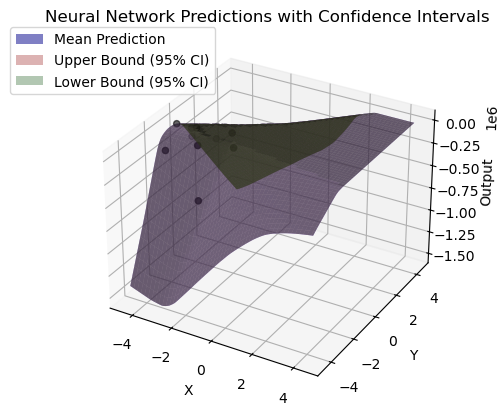

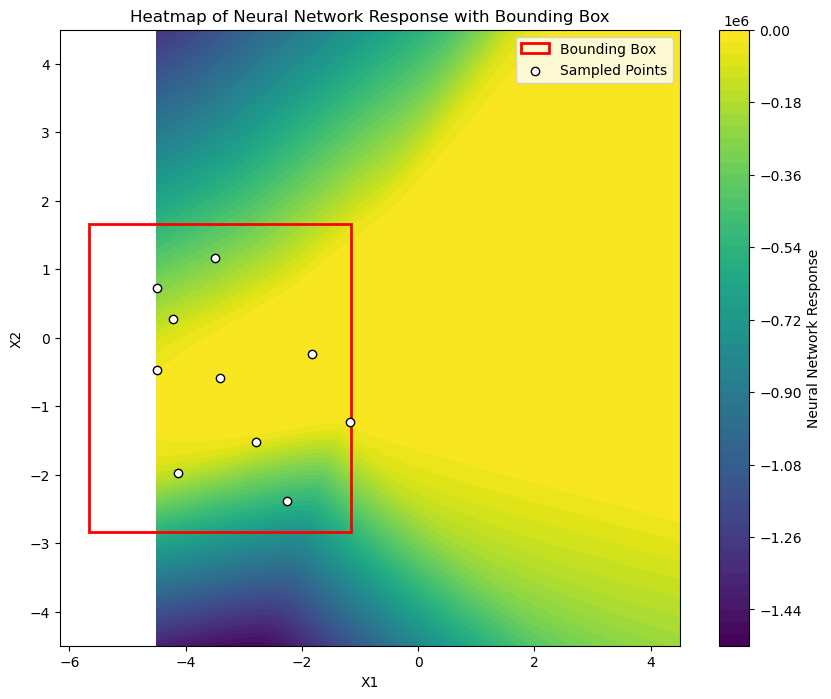

In [68]:
df_sim, df_new3 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 50
learning_rate: 0.01041335043035492
dropout_rate: 0.0
batch_size: 150
epochs: 178
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2538680832.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2538643456.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2538574592.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2538448384.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2538227456.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2537856000.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2537250560.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2536291584.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2534797568.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2532532480.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2529149952.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - lo

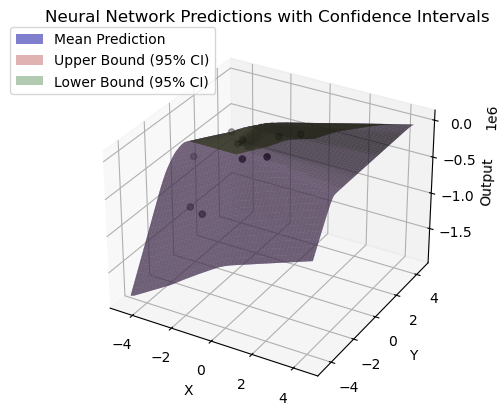

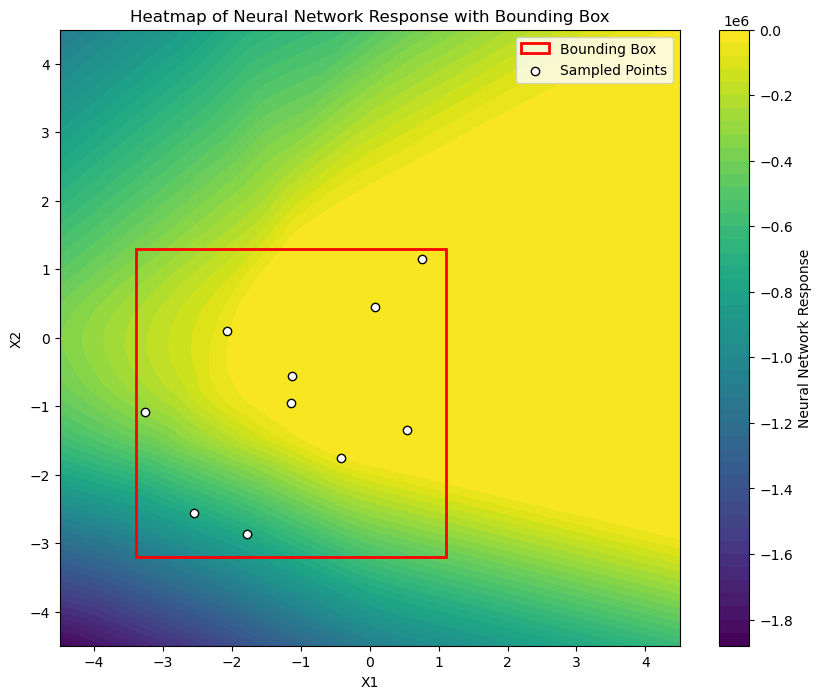

In [69]:
df_sim, df_new3 = perform_iteration(df_sim, df)

In [70]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new3['z'].max()],
                          "Round_num": [3]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [71]:
df = pd.concat([df, df_new3], ignore_index=True)

In [72]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.07420307 -2.94897707]


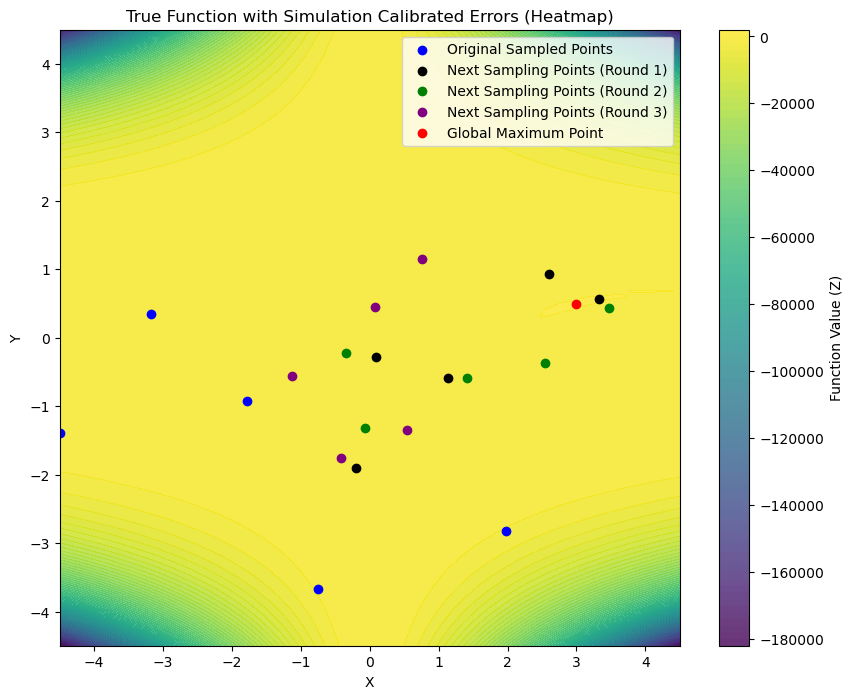

In [73]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [74]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -0.080036         1
2             -0.905159         2
3             -7.803891         3

In [75]:
df_new4 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 2
num_units: 153
learning_rate: 0.0017497654374329416
dropout_rate: 0.0
batch_size: 79
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step - loss: 407031.6250
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 406898.8438
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 406767.0312
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 406636.1875
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 406502.0938
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 406365.4062
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 406225.8750
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 406077.5625
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 405921.2188
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 405757.3750
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 405583.5625
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 405396.6875
Epoch 13/200
1/1 ━━━━━━

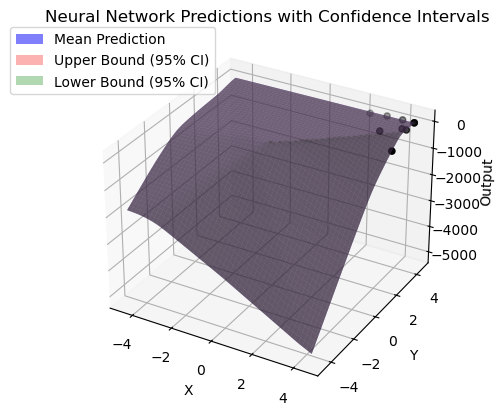

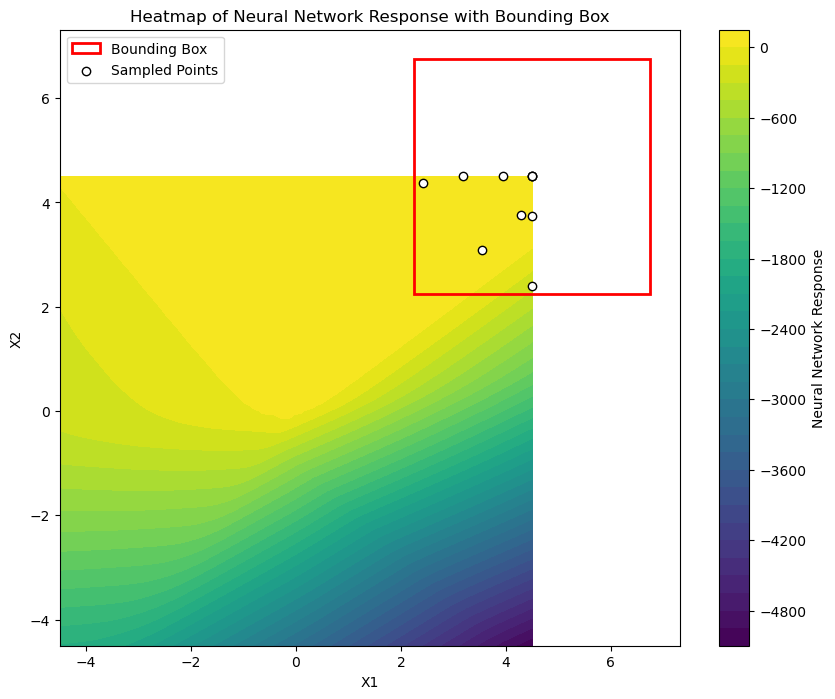

In [76]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 176
learning_rate: 0.008634697072144546
dropout_rate: 0.0
batch_size: 33
epochs: 149
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4193378816.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4193228032.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4192813824.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4191800576.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4189663488.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4185677568.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4178777600.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4167506688.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4149909760.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4123470336.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4084673280.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - l

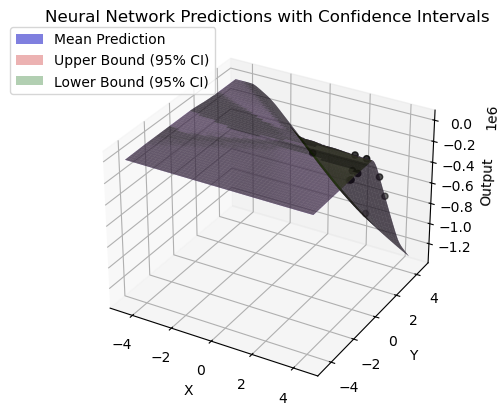

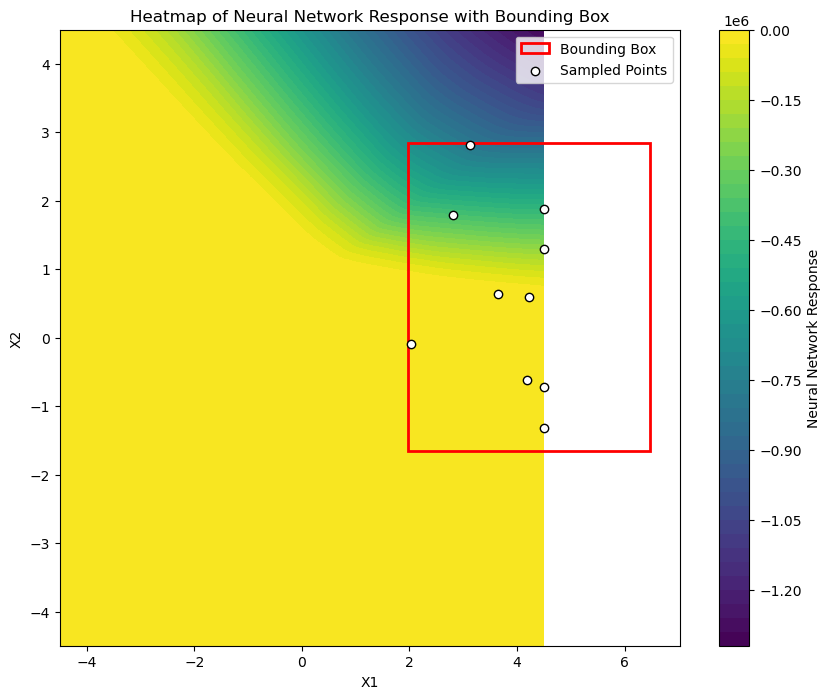

In [77]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.007044247082777664
dropout_rate: 0.09273112637129521
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3145789952.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3145766912.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3145746944.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3145731072.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3145697792.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3145662976.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3145615104.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3145528832.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3145402368.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3145253376.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3145035008.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

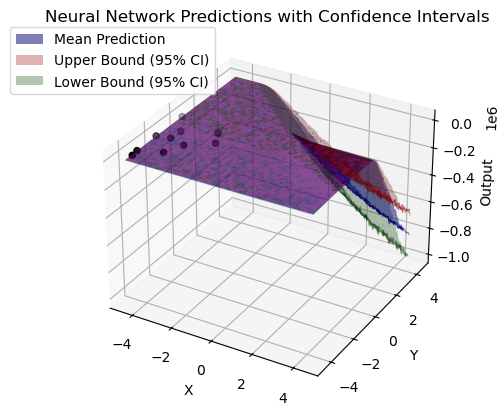

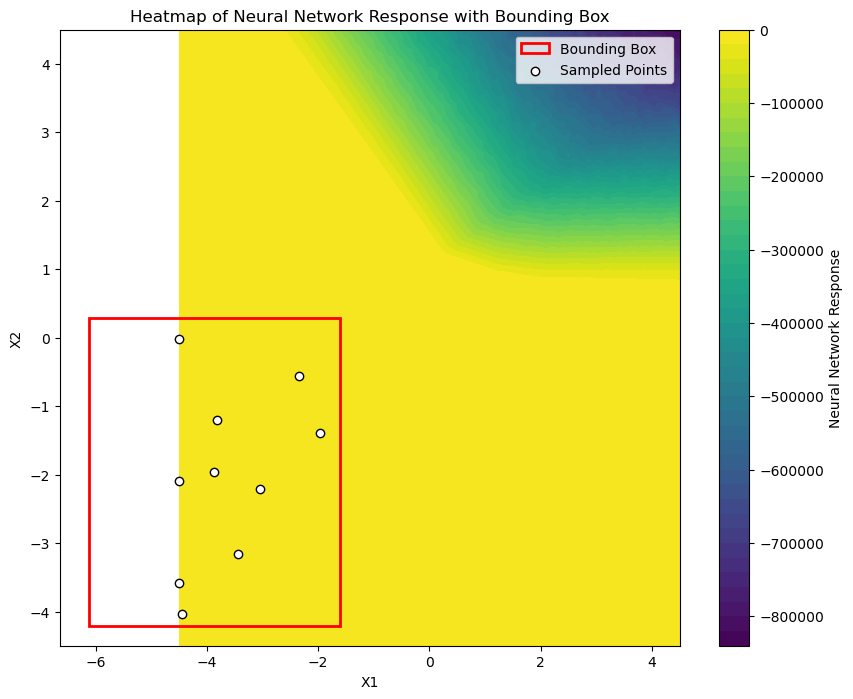

In [78]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0019147275629855388
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2748208384.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2748201728.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2748179200.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2748118272.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2747962880.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2747596288.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2746772992.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2744982528.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2741205248.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2733493504.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2718266112.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 

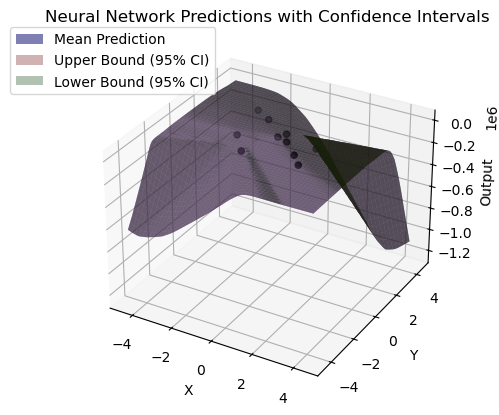

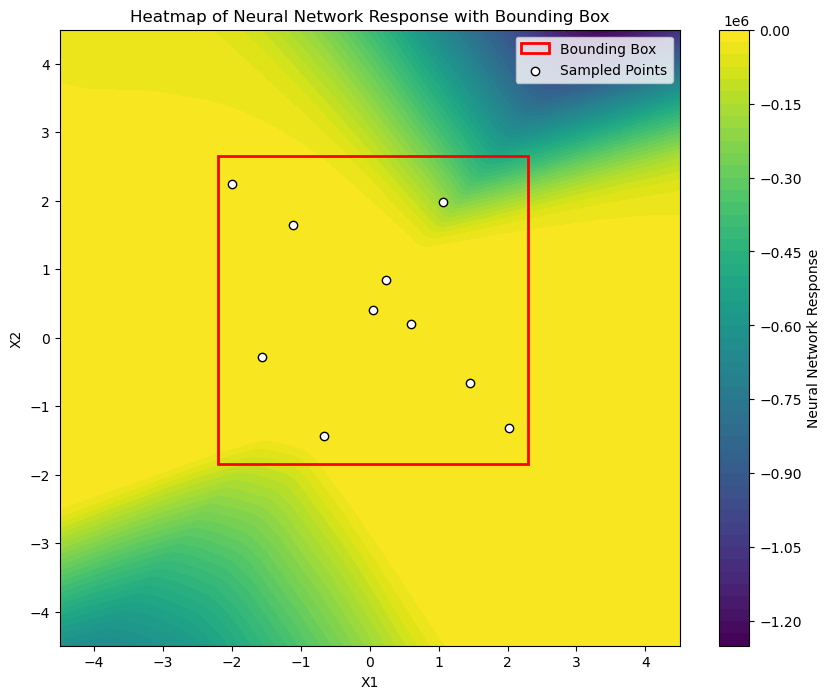

In [79]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 50
learning_rate: 0.008699421923736805
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2290176000.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2290167040.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2290150400.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2290119936.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2290065920.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2289971200.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2289805568.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2289527552.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2289065728.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2288317952.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2287132416.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - l

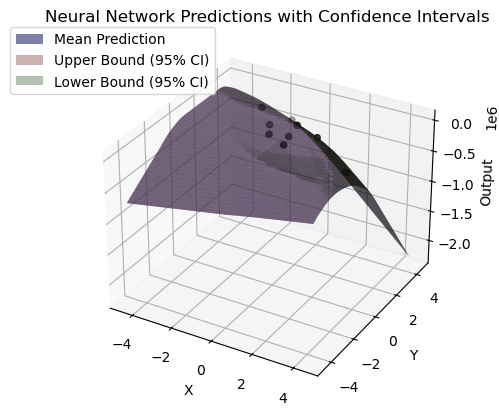

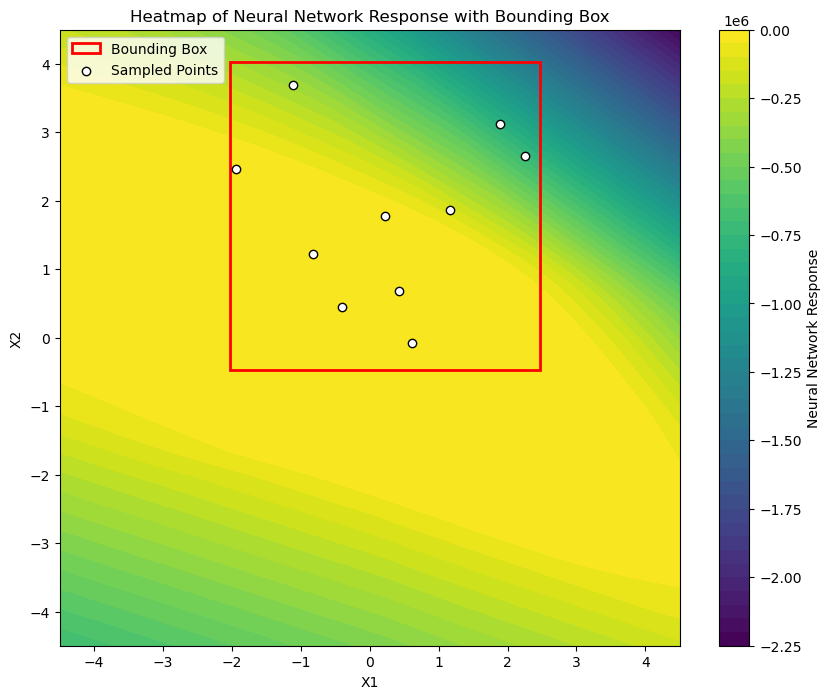

In [80]:
df_sim, df_new4 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 50
learning_rate: 0.005834144603168386
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1963401472.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1963387136.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1963374592.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1963357696.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1963333248.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1963297408.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1963245440.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1963169664.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1963060480.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1962905472.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1962686464.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

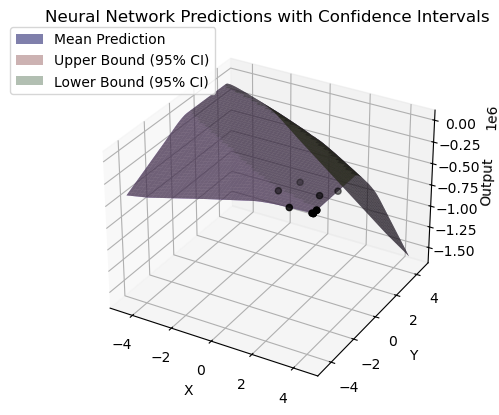

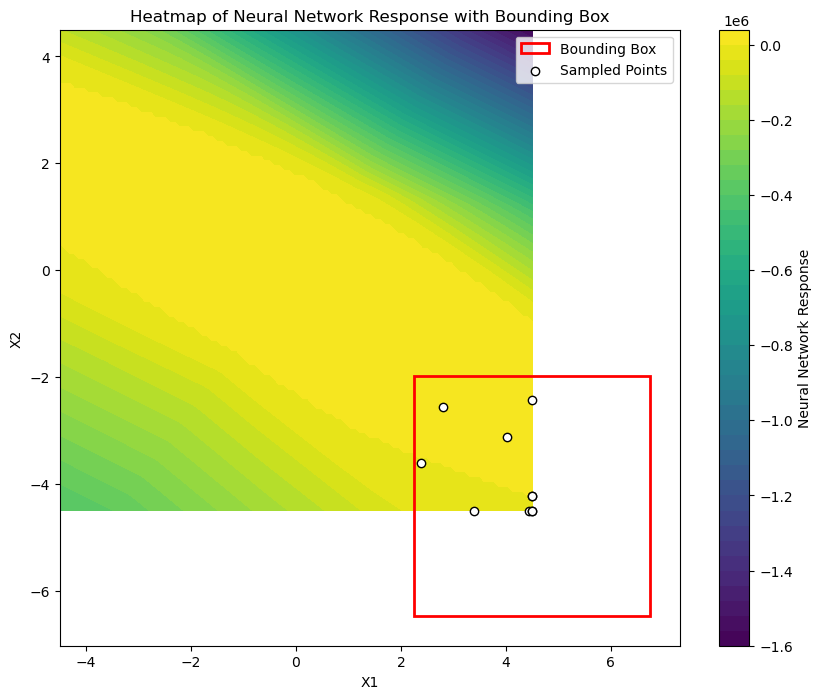

In [81]:
df_sim, df_new4 = perform_iteration(df_sim, df)

In [82]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new4['z'].max()],
                          "Round_num": [4]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

In [83]:
df = pd.concat([df, df_new4], ignore_index=True)

In [84]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.25795609 -2.67978813]


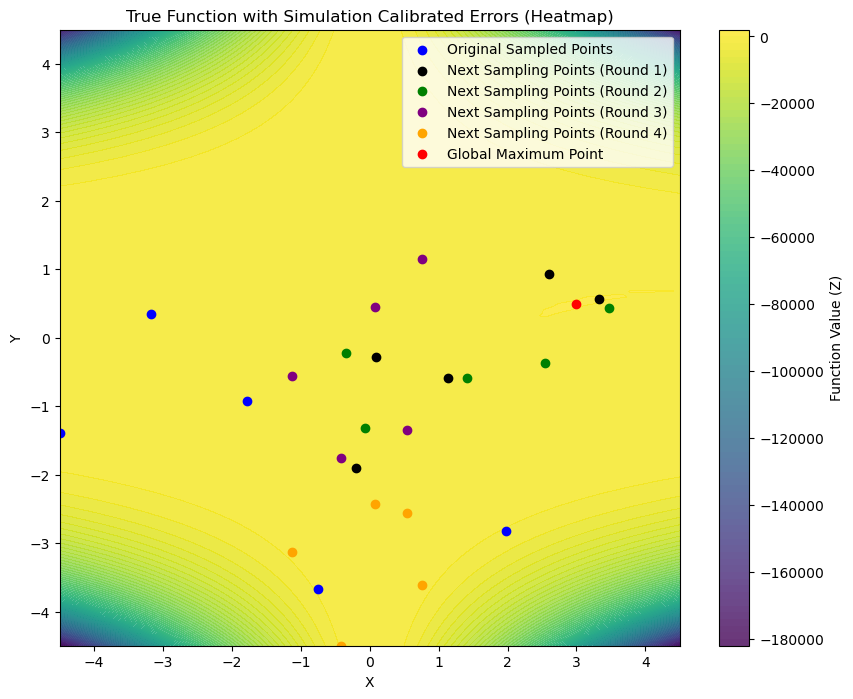

In [ ]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')
ax.scatter(df_new4["x"], df_new4["y"], color='orange', marker='o', label='Next Sampling Points (Round 4)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [86]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -0.080036         1
2             -0.905159         2
3             -7.803891         3
4          -2613.802700         4

In [87]:
df_new5 = pd.DataFrame

df_sim = df.copy()

In [ ]:
df_sim, df_new5 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.00545723165697257
dropout_rate: 0.48513603991282583
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 16980708.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 16979372.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 16975600.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 16967026.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16957540.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 16914404.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 16841392.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 16721349.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 16382533.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 16198318.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 15493552.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 15

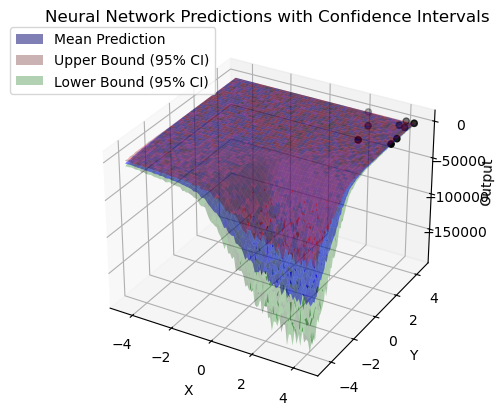

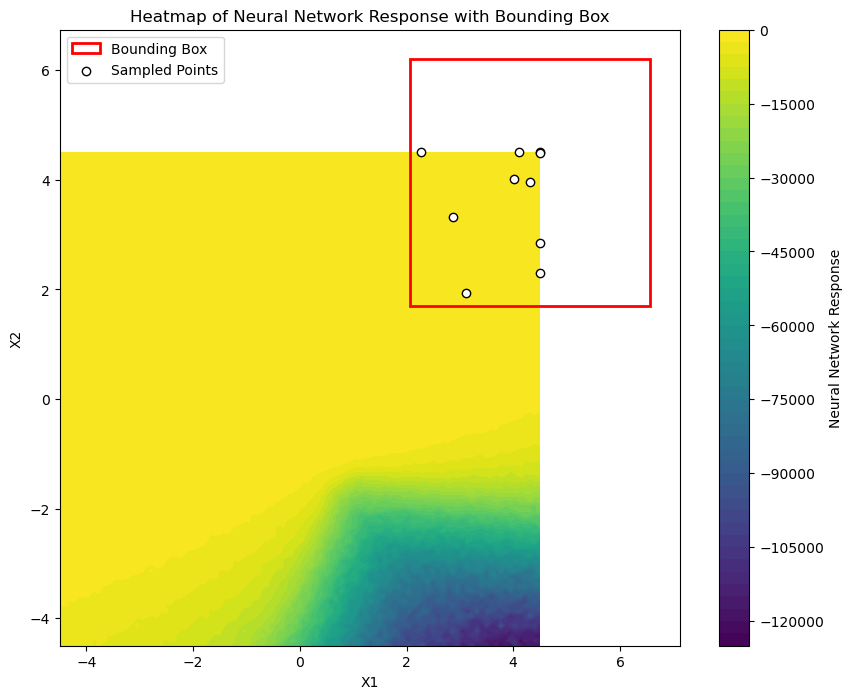

In [89]:
df_sim, df_new5 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.03224046323693653
dropout_rate: 0.0
batch_size: 124
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - loss: 2108056064.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2107827840.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2107336960.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2106392960.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2104819200.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2102436736.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2099037056.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2094393472.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2088258944.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2080366464.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2070436224.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 

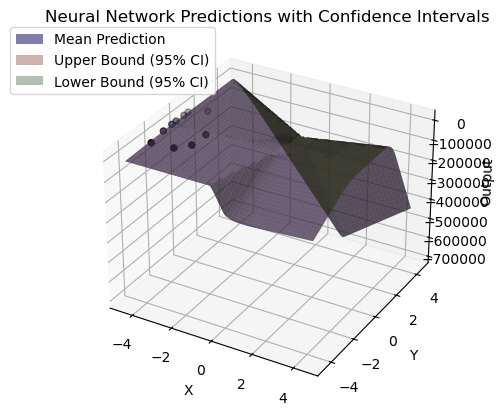

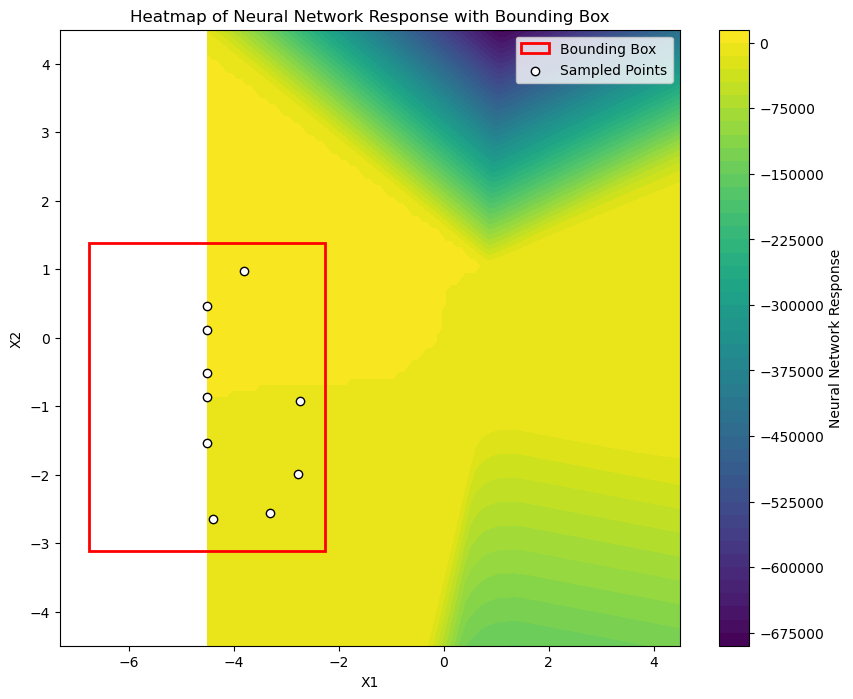

In [90]:
df_sim, df_new5 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1726504960.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1666235515273216.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1727276672.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1727939712.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1704864128.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1354470656.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1589707904.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1196358784.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1614867456.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4151651328.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 22151284736.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 859

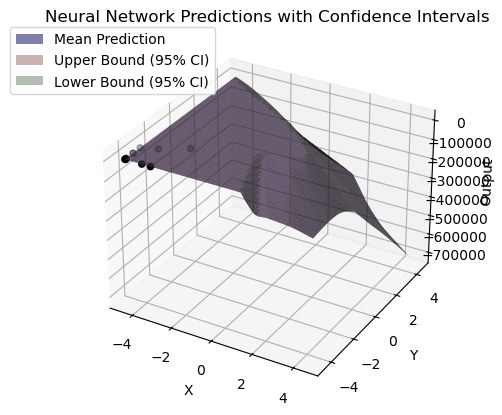

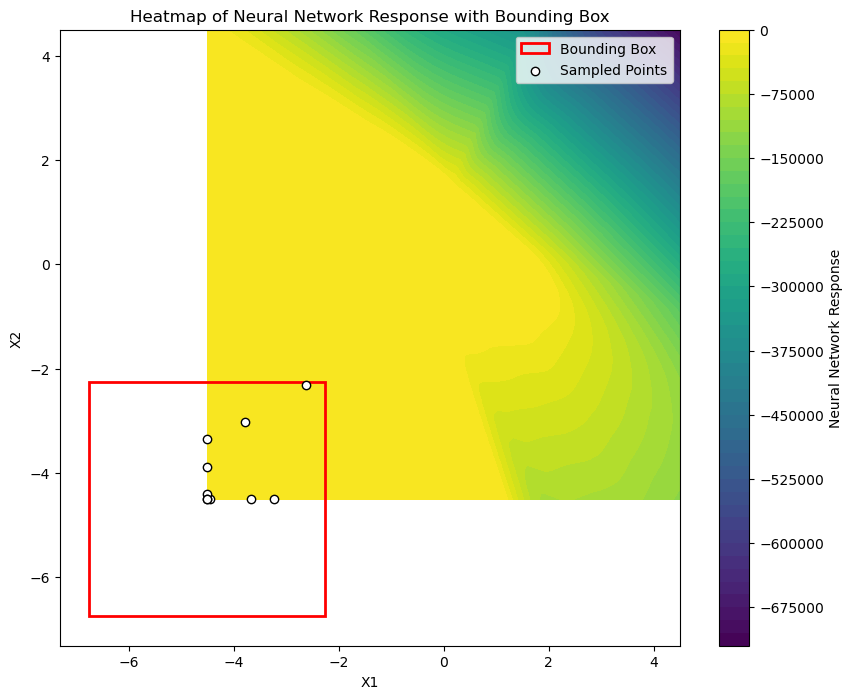

In [91]:
df_sim, df_new5 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 174
learning_rate: 0.0026933900044368944
dropout_rate: 0.0
batch_size: 150
epochs: 130
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3847142656.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3847132160.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3847098880.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3847018240.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 3846832384.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3846419712.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3845551104.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3843786240.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3840355584.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3833827328.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3821787136.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step -

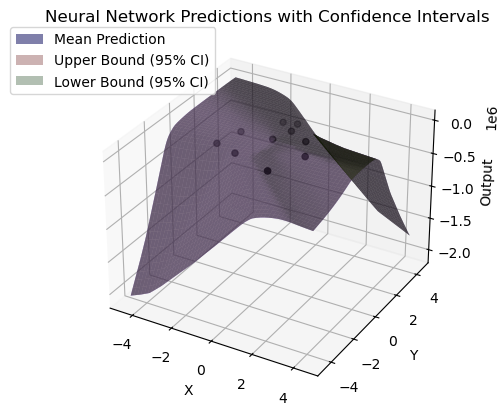

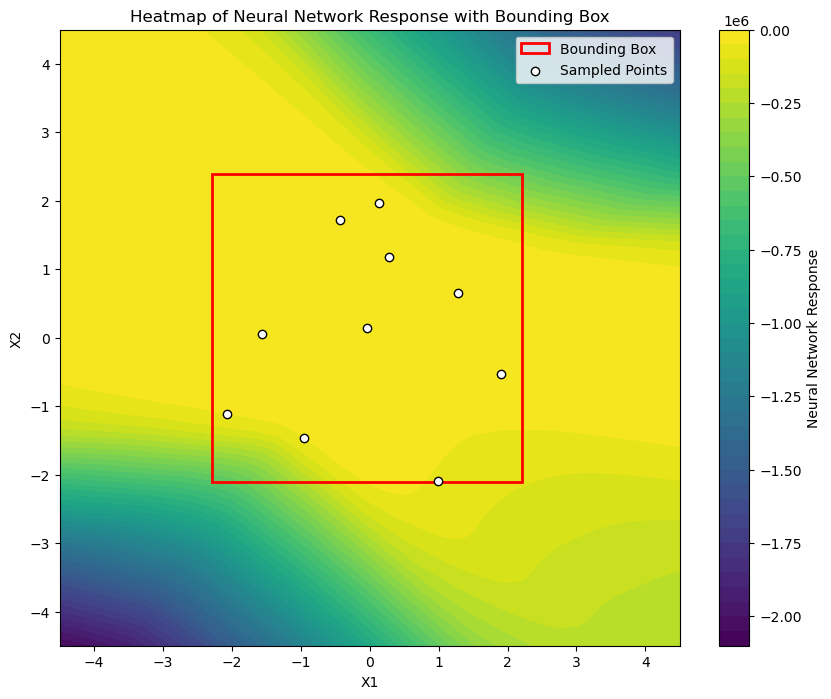

In [92]:
df_sim, df_new5 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 9
num_units: 200
learning_rate: 0.00116767710472015
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 3334190080.0000
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3334185728.0000
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3334177024.0000
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3334159616.0000
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3334129408.0000
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3334077952.0000
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3333991168.0000
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3333844992.0000
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3333601536.0000
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3333203456.0000
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3332556288.0000
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - l

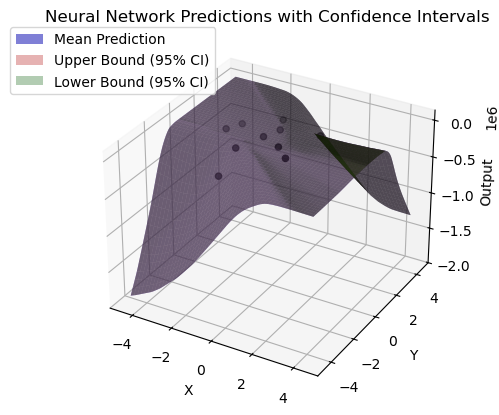

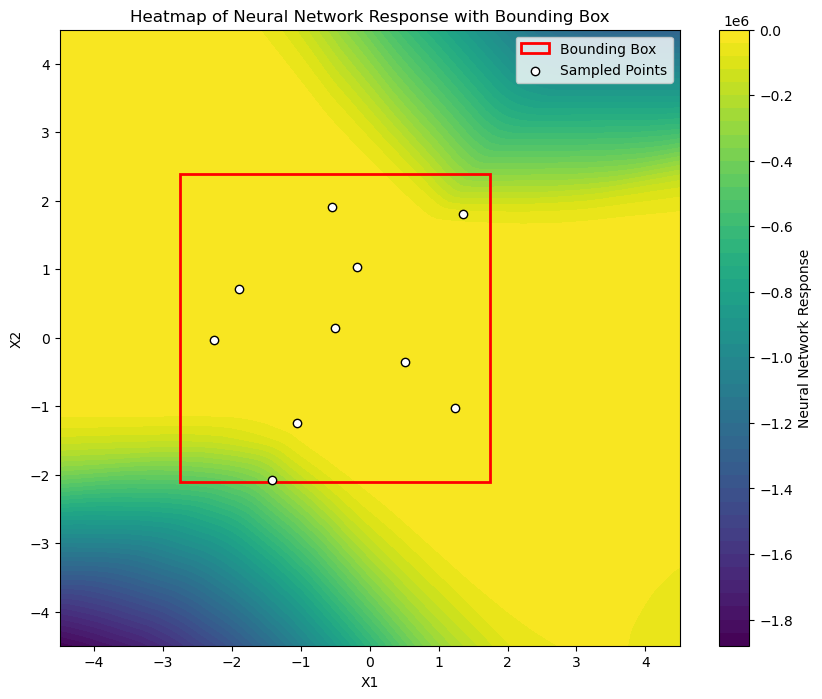

In [93]:
df_sim, df_new5 = perform_iteration(df_sim, df)

In [94]:
new_entry1 = pd.DataFrame({"Highest_phy_Response": [df_new5['z'].max()],
                          "Round_num": [5]})
round_val_df = pd.concat([round_val_df, new_entry1], ignore_index=True)

df = pd.concat([df, df_new5], ignore_index=True)

In [74]:
round_val_df.to_excel("ENN_round.xlsx", index=False) 

In [95]:
df = pd.concat([df, df_new5], ignore_index=True)

In [96]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.26203843 -2.90155179]


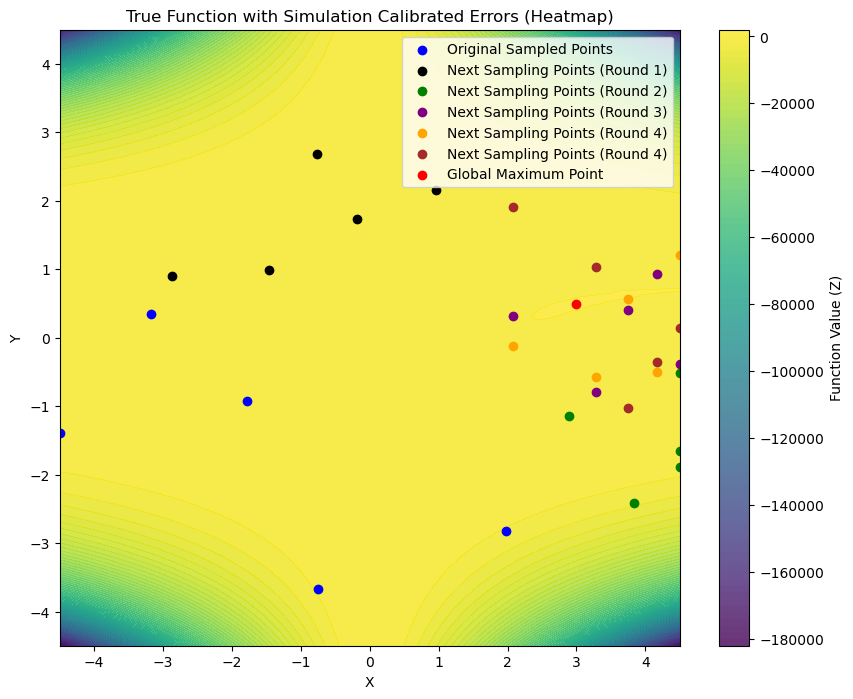

In [97]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')
ax.scatter(df_new3["x"], df_new3["y"], color='purple', marker='o', label='Next Sampling Points (Round 3)')
ax.scatter(df_new3["x"], df_new4["y"], color='orange', marker='o', label='Next Sampling Points (Round 4)')
ax.scatter(df_new3["x"], df_new5["y"], color='brown', marker='o', label='Next Sampling Points (Round 5)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [98]:
round_val_df

Highest_phy_Response Round_num
0            -64.660164         0
1             -8.567064         1
2            -35.128457         2
3             -0.440743         3
4             -2.014529         4
5             -2.122798         5

In [ ]:
data = {'Highest_phy_Response': [-64, -8.5, -35, -0.44, -2.01], 'Round_num': [0, 1, 2, 3, 4]}
df = pd.DataFrame(data)